# Project 1: Forecast SPY future values.
## Josh Greenert 2/4/2023
### Collect Data

In [51]:
# Pulled data into Google Sheet for SPY close data.
# https://docs.google.com/spreadsheets/d/1x-WmNLFdGM-m1zSTUSt2YZ7RY_dVa4CtOr8Y05S5WvU/edit#gid=0
import pandas as pd

df_spy = pd.read_excel("SPY Forecast.xlsx")
df_spy.head(5)

,Date,Close
0,2000-01-03 16:00:00,145.44
1,2000-01-04 16:00:00,139.75
2,2000-01-05 16:00:00,140.00
3,2000-01-06 16:00:00,137.75
4,2000-01-07 16:00:00,145.75


### Plot the Data

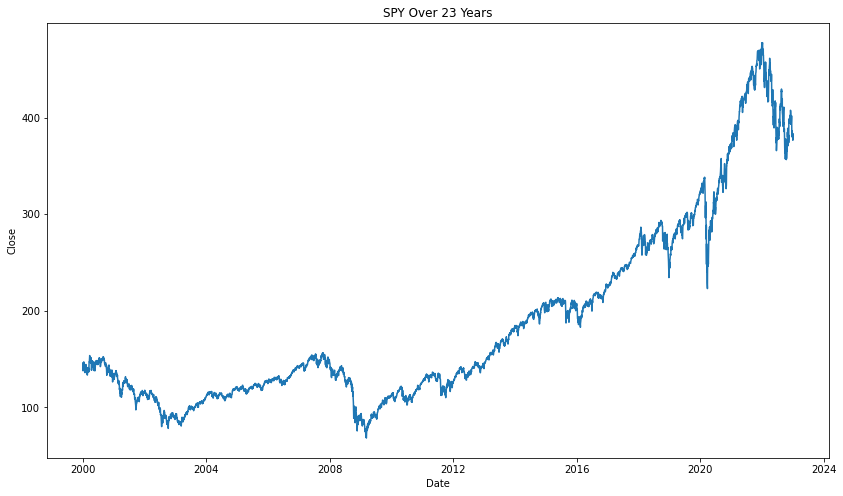

In [52]:
# Data is set in datetime format.  Line graphs view that data fairly well.
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(14, 8))
plt.plot(df_spy.Date, df_spy.Close)
plt.title('SPY Over 23 Years')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

### Prepare Data

In [53]:
# remove all days from the data to create a second model for monthly
df_monthlySpy = df_spy

# Set the values for the monthly dataframe.
df_monthlySpy.set_index('Date', inplace=True)
df_monthlySpy.index = pd.to_datetime(df_monthlySpy.index)
df_monthlySpy = df_monthlySpy.resample('1M').mean()

In [54]:
# Show the head of the data to confirm success.
df_monthlySpy.head(5)

,Close
Date,
2000-01-31,142.719000
2000-02-29,139.071000
2000-03-31,144.636087
2000-04-30,146.232105
2000-05-31,142.080000


### Split the Data Into Test and Train Set

In [71]:
# Set the dates to the beginning of January 2021
testDailyData = df_spy[-503:]
testMonthlyData = df_monthlySpy[-24:]

trainDailyData = df_spy[:-503]
trainMonthlyData = df_monthlySpy[:-24]

### Train the Set To Build a Predictive Model

In [78]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# set the daily.
trainDailyData.index = pd.to_datetime(trainDailyData.index)

# Set the monthly.
trainMonthlyData.index = pd.to_datetime(trainMonthlyData.index)

# Use the sarima model for seasonal time forecasting.
dailyModel = sm.tsa.SARIMAX(trainDailyData, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
dailyModelFit = dailyModel.fit()

# Set the monthly.
monthlyModel = sm.tsa.SARIMAX(trainMonthlyData, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
monthlyModelFit = monthlyModel.fit()

### Make Some Predictions

In [82]:
# Predict the future forecast using the new model.
dailySpyForecast = dailyModelFit.predict(start=pd.to_datetime('2021-04-01'), end=pd.to_datetime(trainDailyData.shape[0]), dynamic=False)
monthlySpyForecast = monthlyModelFit.predict(start=pd.to_datetime('2021-04-01'), end=pd.to_datetime('2022-12-30'), dynamic=False)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [80]:
trainDailyData.tail(5)

,Close
Date,
2020-12-24 13:00:00,369.00
2020-12-28 16:00:00,372.17
2020-12-29 16:00:00,371.46
2020-12-30 16:00:00,371.99
2020-12-31 16:00:00,373.88
